In [751]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx
import dijkstra
import math

import importlib
importlib.reload(dijkstra)
from heapq import heappush, heappop

In [752]:
# パラメータクラス
class Parameter:
    def __init__(self, phi, rho, t, nu, d, N,subq):
        self.phi = phi
        self.rho = rho
        self.t   = t
        self.nu  = nu
        self.d   = d
        self.N   = N # Number of Nodes
        self.subq=subq
# コリドーネットワークの構築
def create_corridor_network(prm):
    N = prm.N
    Nodes = {}
    
    Links = {}
    Nodes_Links = {}
    Linkcosts = {}
    
    Nodes[0] = {}
    Nodes[0]['idx'] = 0
    Nodes[0]['out_link_list'] = []
    Nodes[0]['in_link_list'] = []
    Nodes[0]['spl'] = 0.0
    Nodes[0]['flag'] = 0
    Nodes[0]['previous_node'] = []
    Nodes[0]['previous_link'] = []
    Nodes[0]['sp_spl']=0.0
    Nodes[0]['sp_flag']=0
    link_idx = 0
    # G link
    for from_node in range(1,N):
        for to_node in range(N):
            if from_node == to_node:
                continue
            else:
                Links[link_idx] = {}
                Links[link_idx]['from_node'] = from_node
                Links[link_idx]['to_node'] = to_node
                Links[link_idx]['flow'] = 0.0
                Links[link_idx]['distance'] = abs(from_node - to_node)*prm.d
                if abs(from_node - to_node) == 1:
                    Links[link_idx]['cost'] = prm.t
                elif Links[link_idx]['flow'] != 0:
                    Links[link_idx]['cost'] = (prm.phi+prm.rho*abs(from_node - to_node)*prm.d)/Links[link_idx]['flow']
                else:
                    Links[link_idx]['cost'] = float('inf')
                
                
                Nodes_Links[(from_node, to_node)] = link_idx
                
            if Nodes.get(from_node):
                Nodes[from_node]['out_link_list'] = Nodes[from_node]['out_link_list'] + [link_idx]
            else:
                Nodes[from_node] = {}
                Nodes[from_node]['idx'] = from_node
                Nodes[from_node]['out_link_list'] = [link_idx]
                Nodes[from_node]['in_link_list'] = []
                Nodes[from_node]['spl'] = float('inf')
                Nodes[from_node]['flag'] = 1
                Nodes[from_node]['previous_node'] = None
                Nodes[from_node]['previous_link'] = None
                Nodes[from_node]['sp_spl'] = float('inf')
                Nodes[from_node]['sp_flag'] = 1
            if Nodes.get(to_node):
                Nodes[to_node]['in_link_list'] = Nodes[to_node]['in_link_list'] + [link_idx]
            else:
                Nodes[to_node] = {}
                Nodes[to_node]['idx'] = to_node
                Nodes[to_node]['out_link_list'] = []
                Nodes[to_node]['in_link_list'] = [link_idx]
                Nodes[to_node]['spl'] = float('inf')
                Nodes[to_node]['flag'] = 1
                Nodes[to_node]['previous_node'] = None
                Nodes[to_node]['previous_link'] = None
                Nodes[to_node]['sp_spl'] = float('inf')
                Nodes[to_node]['sp_flag'] = 1
            link_idx = link_idx + 1
            
          
                
    return Links, Nodes, Nodes_Links,link_idx

In [753]:
prm = Parameter(phi=1, rho=0.7, t=1, nu=5.0, d=0.05, N=101,subq=1)
Links, Nodes, Nodes_Links, link_idx= create_corridor_network(prm)

In [754]:
#t=0.1, nu=5.0, d=0.05, N=101

In [755]:
#メモ：previous_nodeは各ノードから0に向かって遡る方向!!

In [756]:
#グラフの設定ここから

In [757]:
def plot_change_graph(Nodes,Links,num_links,Linkflow,counter,Old_flow,change_counter):
    # networkxを用いた可視化

    
    if np.all(Old_flow == Linkflow):
        return change_counter
    
    else:
        MTcount=0
        ITcount=0
    
        G_IT_link = nx.DiGraph()
        G_MT_link = nx.DiGraph()
        
        # 描画のために位置情報を与える
        pos  = {
            node['idx'] : (node['idx']*20.0, 0.0)
            for node in Nodes.values()
        }
        
        # 隣合うノードを結ぶリンクはITリンク，それ以外はMTリンク．フローが流れている場合のみ描画．
        for l in range(num_links):
            if abs(Links[l]['from_node'] -Links[l]['to_node']) == 1:
                if Linkflow[l] !=0:
                    G_IT_link.add_edge(Links[l]['from_node'], Links[l]['to_node'])
                    ITcount=ITcount+1
            elif Linkflow[l]!=0:
                G_MT_link.add_edge(Links[l]['from_node'], Links[l]['to_node'])
                MTcount=MTcount+1
                
        # print("一般リンク本数：",ITcount,"本")
        # print("トランクリンク本数：",MTcount,"本")
        plt.figure(figsize=(100, 20))
        plt.gca().spines['right'].set_visible(True)
        plt.gca().spines['top'].set_visible(True)
        plt.gca().spines['bottom'].set_visible(True)
        plt.gca().spines['left'].set_visible(True)
        
        nx.draw_networkx(G_IT_link, pos=pos, node_size=700, edge_color='black', node_color='white', with_labels=True, font_size=20, edgecolors='black', connectionstyle='arc3,rad=0')
        nx.draw_networkx(G_MT_link, pos=pos, node_size=700, style='dashed',edge_color='black', node_color='white', with_labels=True, font_size=20, edgecolors='black', connectionstyle='arc3,rad=0.3')
      
        # plt.savefig(f'normal_network{change_counter}.png',bbox_inches="tight")
        
    
        change_counter=change_counter+1
    
        return change_counter

In [758]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams["font.size"] = 18
def simple_plot(Nodes, Links, Q, counter, msize=5, linescale=False): 
    right_triangle_set = set([])
    left_triangle_set  = set([])
    
    for node_idx in Nodes.keys():
        if node_idx==0:
            continue
        previous_node_idx = Nodes[node_idx]['previous_node']
        link_idx = Nodes_Links[(node_idx, previous_node_idx)]
        link = Links[link_idx]
        
        if node_idx - previous_node_idx == -1:
            right_triangle_set.add(node_idx)
        elif node_idx - previous_node_idx == 1:
            left_triangle_set.add(node_idx)
        
        # if 0.0 < Q[link_idx] <= prm.Q_over[link_idx]:
        #     if link['from_node'] > link['to_node']:
        #         # ITリンクを再帰的にReduceする
        #         for i in range(link['to_node']+1, link['from_node']+1):
        #             left_triangle_set.add(i)
        #     else:
        #         for i in range(link['from_node'], link['to_node']):
        #             right_triangle_set.add(i)
    
    plt.figure(figsize=(10, 2))
    
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    # plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
        
    plt.xlim([0, prm.N])
    plt.ylim([-1,50])
    for node_idx in right_triangle_set:
        plt.plot([node_idx], [0.0], marker='>', color='blue', markersize=msize)
    for node_idx in left_triangle_set:
        plt.plot([node_idx], [0.0], marker='<', color='red', markersize=msize)
        
    for node_idx in set(Nodes.keys()) - set([0]) - right_triangle_set - left_triangle_set:
        previous_node_idx = Nodes[node_idx]['previous_node']
        x_list = np.linspace(node_idx, previous_node_idx, 20)
        
        r = (1.0/2.0)*(node_idx - previous_node_idx)
        center = previous_node_idx + r
        
        y_list = np.vectorize(lambda x: np.sqrt(r**2 - (x-center)**2))(x_list)
        
        rank = np.array([Q[node['out_link_list']].sum() for node in Nodes.values()])
        rank_sum = rank.sum()
        
        if linescale:
            linew=20*(rank[node_idx]/rank_sum)
        else:
            linew=1
        if node_idx > previous_node_idx:
            plt.plot(x_list, y_list, color='red',linewidth=linew)
        else:
            plt.plot(x_list, y_list, color='blue',linewidth=linew)
    
    plt.tick_params(labelbottom=True, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(bottom=True, left=False, right=False, top=False)
    
    # plt.savefig(f'normal_network_{counter}.png',bbox_inches="tight")
    
    MTcount=0
    ITcount=0
    
    for l in range(len(Links)):
        if abs(Links[l]['from_node'] -Links[l]['to_node']) == 1:
            if Linkflow[l] !=0:
                ITcount=ITcount+1
        elif Linkflow[l]!=0:
            MTcount=MTcount+1
    
    # print("一般リンク本数：",ITcount,"本")
    # print("トランクリンク本数：",MTcount,"本")
            
    return True


In [759]:
def plot_change_graph_matplotlib(Nodes,Links,num_links,Linkflow,counter,Old_flow,change_counter):
    # matplotlibを用いた可視化

    
    if np.all(Old_flow == Linkflow):
        return change_counter
    
    else:
        simple_plot(Nodes, Links, Linkflow, counter,msize=5, linescale=False)
        plt.tick_params(labelbottom=True, labelleft=False, labelright=False, labeltop=False)
        plt.tick_params(bottom=True, left=False, right=False, top=False)
        
        # plt.savefig(f'networkchange_matplotlib{change_counter}.png',bbox_inches="tight")
        
        change_counter=change_counter+1
    
        return change_counter

In [760]:
def plot_graph(Nodes,Links,num_links,Linkflow,counter):
    # networkxを用いた可視化
    MTcount=0
    ITcount=0
    
        
    G_IT_link = nx.DiGraph()
    G_MT_link = nx.DiGraph()
    
    # 描画のために位置情報を与える
    pos  = {
        node['idx'] : (node['idx']*20.0, 0.0)
        for node in Nodes.values()
    }
    
    # 隣合うノードを結ぶリンクはITリンク，それ以外はMTリンク．フローが流れている場合のみ描画．
    for l in range(num_links):
        if abs(Links[l]['from_node'] -Links[l]['to_node']) == 1:
            if Linkflow[l] !=0:
                G_IT_link.add_edge(Links[l]['from_node'], Links[l]['to_node'])
                ITcount=ITcount+1
        elif Linkflow[l]!=0:
            G_MT_link.add_edge(Links[l]['from_node'], Links[l]['to_node'])
            MTcount=MTcount+1
    
    print("一般リンク本数：",ITcount,"本")
    print("トランクリンク本数：",MTcount,"本")
    
    plt.figure(figsize=(60, 20))
    plt.gca().spines['right'].set_visible(True)
    plt.gca().spines['top'].set_visible(True)
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().spines['left'].set_visible(True)
    
    nx.draw_networkx(G_IT_link, pos=pos, node_size=700, edge_color='black', node_color='white', with_labels=True, font_size=20, edgecolors='black', connectionstyle='arc3,rad=0')
    nx.draw_networkx(G_MT_link, pos=pos, node_size=700, edge_color='red', node_color='white', with_labels=True, font_size=20, edgecolors='black', connectionstyle='arc3,rad=0.2')
    plt.savefig(f'normal_network_{counter}.png',bbox_inches="tight")
        
        
    return True

In [761]:
#グラフ出力ここまで

In [762]:
#初期設定ここから

In [763]:
#【Frank-Wolfe法】必要な配列を定義する（最初は全てのリンクのフローを0にする）
num_links=len(Links)
num_nodes=len(Nodes)

Linkflow=np.zeros(num_links)
calc_flow=np.zeros(num_links)
cost_arr_fr=np.zeros(num_links)

#初期の実行可能フローの作成

for link_idx in range(num_links):
    if Links[link_idx]["from_node"]-Links[link_idx]["to_node"]==1:
        Linkflow[link_idx]=(prm.N-Links[link_idx]["from_node"])*prm.nu

#初期のprevious_nodeの設定
for i in range(1,prm.N):
    Nodes[i]['previous_node']=i-1
    Nodes[i]['previous_link']=Nodes_Links[(i,i-1)]

In [764]:
#収束判定用の番号を格納する配列．各ノードについて番号が付与される．
conv_number=np.zeros(num_nodes)


conv_number[0]=0


#計算回数のカウンター
counter=1

counterflow=np.zeros(num_links)

change_counter=0

In [765]:
# simple_plot(Nodes, Links, Linkflow, counter,msize=5, linescale=False)
# plt.tick_params(labelbottom=True, labelleft=False, labelright=False, labeltop=False)
# plt.tick_params(bottom=True, left=False, right=False, top=False)

In [766]:
def changecount(Nodes,Links,num_links,Linkflow,counter,Old_flow,change_counter):
    if np.all(Old_flow == Linkflow):
        return change_counter
    
    else:
        change_counter=change_counter+1
        return change_counter    

In [767]:
# for idx in range(len(Links)):
#     print("----")
#     print(idx)
#     print("----")
#     print(Links[idx]['from_node'])
#     print(Links[idx]['to_node'])
#     print(Linkflow[idx])

In [768]:
m = dijkstra.Model(Nodes,Links)

In [769]:
#初期設定ここまで
#計算ここから

In [770]:
#【Frank-Wolfe法】リンクフローからコストを算出する
def make_cost_arr_fr(Links,Linkflow,cost_arr_fr):
    #各リンクについての検討
    for idx in range(len(Links)):
        #ITリンクの場合
        if abs(Links[idx]["from_node"]-Links[idx]["to_node"])==1:
            cost_arr_fr[idx]=prm.t*prm.d
        #MTリンクの場合（従来型とは関数が少しだけ異なる）
        else:
            cost_arr_fr[idx]=(prm.phi+prm.rho*abs(Links[idx]["from_node"]-Links[idx]["to_node"])*prm.d)/(Linkflow[idx]+prm.subq)
        
    
    #コストを返す
    return cost_arr_fr

In [771]:
#収束判定の関数

def convergence_judgment(tr,Old_flow,Linkflow,conv_number):
    
    #Old_flowとLinkflowの差の二乗和
    
    difference=np.zeros(num_links)
    difference=abs(Old_flow-Linkflow)
    
    
    #Old_flowとLinkflowが完全に一致していれば0を，そうでなければ1を付与
    
    if np.all(difference<10**(-2)):
        conv_number[tr]=0
    else:
        conv_number[tr]=1
    
    
    #conv_numberとOld_flowを返す
    
    return conv_number

In [772]:
#ハブ階層の最大値を求める関数
def max_hub_level(Nodes,num_links):
    hublevel=np.zeros(num_links)
    
    for node_idx in range(1,prm.N):
        
        idx_node=node_idx
        
        while idx_node!=0:
            
            prev_idx_node=Nodes[idx_node]['previous_node']
            
            if abs(prev_idx_node-idx_node)!=1:
                hublevel[node_idx]=hublevel[node_idx]+1
            
            idx_node=prev_idx_node
    
    return np.max(hublevel)
            

In [773]:
#【Frank-Wolfe法】目的関数を算出する関数
def objective_function(Linkflow,Links,object):
    object=0.0
    
    for idx in range(len(Links)):
        if Links[idx]['distance']!=prm.d:
            object=object+(prm.phi+prm.rho*abs(Links[idx]['from_node']-Links[idx]['to_node'])*prm.d)*math.log(Linkflow[idx]+1.0)
        else:
            object=object+prm.t*prm.d*Linkflow[idx]
    
    return object

In [774]:
def inverse_solve_fr(Nodes,Links,cost_arr_fr):#逆向きにしたダイクストラの本体
    inverse_origin=0
    hq = [(0.0,inverse_origin)] # (distance, node)＃hqがヒープ．
        
    Nodes[inverse_origin]['spl'] = 0.0
    Nodes[inverse_origin]['flag'] = 0 # 探索済に変更　#flag=1なら未探索で，flag=0なら探索済み．
    
    #ヒープとは：優先度つきのデータ構造
    
    while hq:
        pivot_node = heappop(hq)[1] #ヒープの先頭を取得(pivot_nodeを決定．これをピボットとして探索)
        #これ以降が普通のものと違う
        #in_linkとout_linkを逆さまに
        #from_nodeとto_nodeを逆さまに
        for l in Nodes[pivot_node]['in_link_list']:#lはin_link_listに含まれるリンク
            from_node = Links[l]['from_node']
            tmp_cost = Nodes[pivot_node]['spl'] + cost_arr_fr[l]#暫定コスト
        
            if tmp_cost < Nodes[from_node]['spl']*float(Nodes[from_node]['flag']): #from_nodeが探索済みの場合はfloatが0になるので，if文が踏まれることはない．
                Nodes[from_node]['spl'] = tmp_cost
                Nodes[from_node]['previous_node'] = pivot_node
                Nodes[from_node]['previous_link'] = l
                heappush(hq, (tmp_cost, from_node)) #未確定ヒープにfrom_nodeを追加　
            
        Nodes[pivot_node]['flag'] = 0 #探索済に変更 pivot_nodeの役割を終えて初めて確定となる．
        
    return Nodes,Links

counter= 0 object= 1262.5
counter= 1 object= 791.7080016135994
counter= 2 object= 539.0181680223467
counter= 3 object= 474.3567249849204
counter= 4 object= 474.3567249849204
phi= 1
rho= 0.7
loop= 3
ハブ階層： 2.0


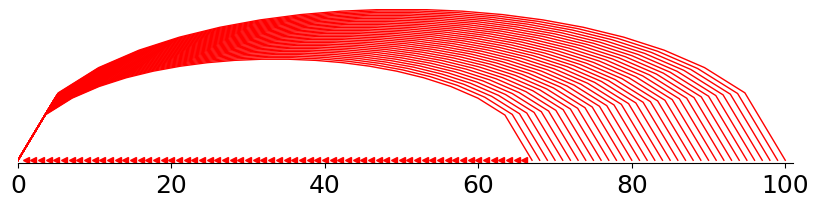

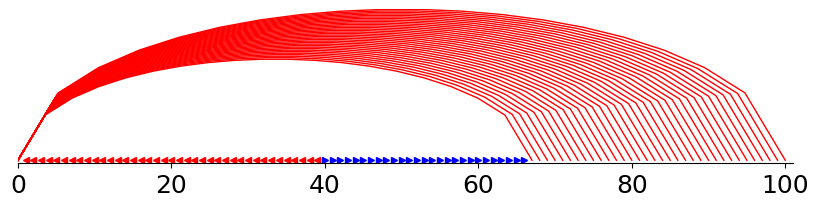

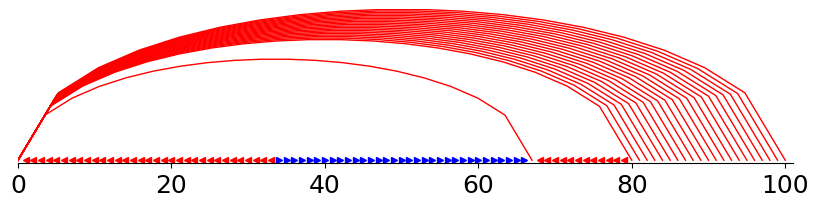

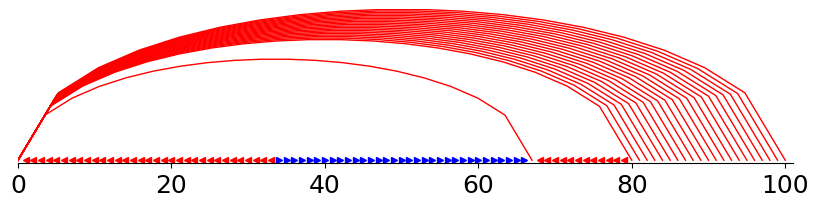

In [775]:
#【Frank-Wolfe法】コード本体

Old_flow=Linkflow.copy()
record_counter=0
print("counter=",0,end=" ")
print("object=",objective_function(Linkflow,Links,object))
while True:

        #計算に使うコストの設定
        
        cost_arr_fr=make_cost_arr_fr(Links,Linkflow,cost_arr_fr)
    
        #最短経路木の決定（ダイクストラ）の初期化
        
        m.reset_node_fr()
        
        
        #最短経路木の決定（ダイクストラ）
         
        Nodes,Links=inverse_solve_fr(Nodes,Links,cost_arr_fr)

        #フローの初期化
        Linkflow=np.zeros(num_links)

        #各ノードに分布する人口を最小費用経路に含まれるリンクに加算
        for i in range(1,prm.N):
            
            idx_node=i
            while idx_node!=0:
            
                prev_idx_node=Nodes[idx_node]['previous_node']
                idx=Nodes_Links[(idx_node, prev_idx_node)]
                Linkflow[idx]=Linkflow[idx]+prm.nu
                idx_node=prev_idx_node
                
        
        
        #フローの変更があったら出力する
        
        change_counter=plot_change_graph_matplotlib(Nodes,Links,num_links,Linkflow,counter,Old_flow,change_counter)
        
        #画像出力なしでchange_counterが欲しい場合はこっちを使う
        # change_counter=changecount(Nodes,Links,num_links,Linkflow,counter,Old_flow,change_counter)
        
        difference=np.zeros(num_links)
        difference=abs(Old_flow-Linkflow)
        
        
        
        
    #収束判定
        if  np.all(difference<10**(-2)):
            print("counter=",counter,end=" ")
            print("object=",objective_function(Linkflow,Links,object))
            print("phi=",prm.phi)
            print("rho=",prm.rho)
            print("loop=",counter-1)
            # print("improve=",change_counter)
            # plot_graph(Nodes,Links,num_links,Linkflow,counter)
            
            simple_plot(Nodes, Links, Linkflow, counter,msize=5, linescale=False)
            plt.tick_params(labelbottom=True, labelleft=False, labelright=False, labeltop=False)
            plt.tick_params(bottom=True, left=False, right=False, top=False)
            
            
            max_hub_level=max_hub_level(Nodes,num_links)
            if max_hub_level!=0:
                max_hub_level=max_hub_level+1
                print("ハブ階層：",max_hub_level)
            
            #ノード0を1として計算
            else:
                print("ハブはありません")
            
            
            # print("done")
            
            break
            
        
        else:
            print("counter=",counter,end=" ")
            print("object=",objective_function(Linkflow,Links,object))
            
            # simple_plot(Nodes, Links, Linkflow, counter,msize=5, linescale=False)
            # plt.tick_params(labelbottom=True, labelleft=False, labelright=False, labeltop=False)
            # plt.tick_params(bottom=True, left=False, right=False, top=False)
            
            # plot_graph(Nodes,Links,num_links,Linkflow,counter)
            # print(f"improve_loop{counter}={change_counter-record_counter}")
            # record_counter=change_counter
            
            counter=counter+1

            #Old_flowの更新
        
            Old_flow=Linkflow.copy()
    
    

In [717]:
#Linkflowが相補性問題を満たしているか確認する
def flow_preserve_test(Nodes,Linkflow):
    for node_idx in range(1,prm.N):
        In_flow_sum=Linkflow[Nodes[node_idx]["in_link_list"]].sum()
        Out_flow_sum=Linkflow[Nodes[node_idx]["out_link_list"]].sum()
        if abs(In_flow_sum+prm.nu-Out_flow_sum)<10**(-6):
            continue
        else:
            print(node_idx)
            return False
   
    return True

In [718]:
def inverse_solve_for_check(Nodes,Links,cost_arr):#逆向きにしたダイクストラの本体
    inverse_origin=0
    hq = [(0.0,inverse_origin)] # (distance, node)＃hqがヒープ．
        
    Nodes[inverse_origin]['spl'] = 0.0
    Nodes[inverse_origin]['flag'] = 0 # 探索済に変更　#flag=1なら未探索で，flag=0なら探索済み．
    
    #ヒープとは：優先度つきのデータ構造
    
    while hq:
        pivot_node = heappop(hq)[1] #ヒープの先頭を取得(pivot_nodeを決定．これをピボットとして探索)
        #これ以降が普通のものと違う
        #in_linkとout_linkを逆さまに
        #from_nodeとto_nodeを逆さまに
        for l in Nodes[pivot_node]['in_link_list']:#lはin_link_listに含まれるリンク
            from_node = Links[l]['from_node']
            tmp_cost = Nodes[pivot_node]['spl'] + cost_arr[l]#暫定コスト
        
            if tmp_cost < Nodes[from_node]['spl']*float(Nodes[from_node]['flag']): #from_nodeが探索済みの場合はfloatが0になるので，if文が踏まれることはない．
                Nodes[from_node]['spl'] = tmp_cost
                Nodes[from_node]['previous_node'] = pivot_node
                Nodes[from_node]['previous_link'] = l
                heappush(hq, (tmp_cost, from_node)) #未確定ヒープにfrom_nodeを追加　
            
        Nodes[pivot_node]['flag'] = 0 #探索済に変更 pivot_nodeの役割を終えて初めて確定となる．
        
    return Nodes,Links

In [719]:
def make_cost_arr(Links,Linkflow,cost_arr):
    #各リンクについての検討
    for idx in range(len(Links)):
        
        #sp-treeの中にあればtemp_Linkflow由来のコストを採用
        
        #ここでの変更点：隣り合うリンク同士のコストがtになっていなかったので，それを反映．
        
        
        if abs(Links[idx]["from_node"]-Links[idx]["to_node"])==1:
            cost_arr[idx]=prm.t*prm.d
    
        else:
            if Linkflow[idx]!=0:
                cost_arr[idx]=(prm.phi+prm.rho*abs(Links[idx]["from_node"]-Links[idx]["to_node"])*prm.d)/(Linkflow[idx]+prm.subq)
            else:
                cost_arr[idx]=(prm.phi+prm.rho*abs(Links[idx]["from_node"]-Links[idx]["to_node"])*prm.d)/(Linkflow[idx]+prm.subq)
       
        
     
    #コストを返す
    cost_arr = np.where(cost_arr==np.inf, 10**8,cost_arr)
    return cost_arr

In [720]:
def min_cost_test(Nodes,Links,Linkflow,cost_arr):
    for idx in range(len(Links)):
        i=Links[idx]['from_node']
        j=Links[idx]['to_node']
        
        if -10**(-6) < (cost_arr[idx]-(Nodes[i]['spl']-Nodes[j]['spl']))*Linkflow[idx] <10**(-6):
            if Linkflow[idx]<0.0:
                print("Error1")
                print("i=",i)
                print("j=",j)
                print("idx=",idx)
                return False
            if cost_arr[idx]-(Nodes[i]['spl']-Nodes[j]['spl'])<-10**(-6):
                print("Error2")
                print("i=",i)
                print("j=",j)
                print("idx=",idx)
                return False
        else:
            print("Error3")
            print("i=",i)
            print("j=",j)
            print("idx=",idx)
            return False
    
    return True

In [721]:
def reset_node(Nodes):#ノードの初期化関数
        for n in Nodes:
            Nodes[n]['spl'] = np.inf #各ノードにおける，起点からの最小コスト
            Nodes[n]['flag'] = 1
            
            #ここでの変更点：child_node_listはこの後のダイクストラ法で探索されない（→previous_nodeやprevious_linkが定義されない）にもかかわらず
            #child_node_listのノードも含めてNoneとしてしまっていたため，計算終了後もNoneとなってしまっていた．
            #なので，child_node_listのノードを除外
        
        return Nodes

In [722]:
flow_preserve_test(Nodes,Linkflow)

True

In [723]:
# for idx in range(len(Links)):
#     print("----")
#     print(idx)
#     print("----")
#     print(Links[idx]['from_node'])
#     print(Links[idx]['to_node'])
#     print("Linkflow=",Linkflow[idx])

In [724]:
cost_arr=np.zeros(num_links)
cost_arr=make_cost_arr(Links,Linkflow,cost_arr)
Nodes=reset_node(Nodes)
Nodes,Links=inverse_solve_for_check(Nodes,Links,cost_arr)
min_cost_test(Nodes,Links,Linkflow,cost_arr)

True

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams["font.size"] = 18
def simple_plot(Nodes, Links, Q, msize=5, linescale=False): 
    right_triangle_set = set([])
    left_triangle_set  = set([])
    
    for node_idx in Nodes.keys():
        if node_idx==0:
            continue
        previous_node_idx = Nodes[node_idx]['previous_node']
        link_idx = Nodes_Links[(node_idx, previous_node_idx)]
        link = Links[link_idx]
        
        if node_idx - previous_node_idx == -1:
            right_triangle_set.add(node_idx)
        elif node_idx - previous_node_idx == 1:
            left_triangle_set.add(node_idx)
        
        # if 0.0 < Q[link_idx] <= prm.Q_over[link_idx]:
        #     if link['from_node'] > link['to_node']:
        #         # ITリンクを再帰的にReduceする
        #         for i in range(link['to_node']+1, link['from_node']+1):
        #             left_triangle_set.add(i)
        #     else:
        #         for i in range(link['from_node'], link['to_node']):
        #             right_triangle_set.add(i)
    
    plt.figure(figsize=(10, 2))
    
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    # plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
        
    plt.xlim([0, prm.N])
    for node_idx in right_triangle_set:
        plt.plot([node_idx], [0.0], marker='>', color='black', markersize=msize)
    for node_idx in left_triangle_set:
        plt.plot([node_idx], [0.0], marker='<', color='black', markersize=msize)
        
    for node_idx in set(Nodes.keys()) - set([0]) - right_triangle_set - left_triangle_set:
        previous_node_idx = Nodes[node_idx]['previous_node']
        x_list = np.linspace(node_idx, previous_node_idx, 20)
        
        r = (1.0/2.0)*(node_idx - previous_node_idx)
        center = previous_node_idx + r
        
        y_list = np.vectorize(lambda x: np.sqrt(r**2 - (x-center)**2))(x_list)
        
        rank = np.array([Q[node['out_link_list']].sum() for node in Nodes.values()])
        rank_sum = rank.sum()
        
        if linescale:
            linew=20*(rank[node_idx]/rank_sum)
        else:
            linew=1
        if node_idx > previous_node_idx:
            plt.plot(x_list, y_list, color='red', linewidth=linew)
        else:
            plt.plot(x_list, y_list, color='blue', linewidth=linew)
            
    return True


In [ ]:
simple_plot(Nodes, Links,  Linkflow, msize=0, linescale=False)
# plt.grid()
plt.tick_params(labelbottom=True, labelleft=False, labelright=False, labeltop=False)
plt.tick_params(bottom=True, left=False, right=False, top=False)